In [1]:
library (tidyverse)
library (tidymodels) 
library(repr)
library(tidyclust)
library(repr)
library(GGally)
library (themis)
options(repr.matrix.max.rows = 7)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Load + Tidy the data + Reduce 

players_data <- read_csv ( "players.csv" ) |> 
    drop_na() |> # drop 2 rows where Age = NA 
    mutate ( subscribe = as_factor (subscribe) ) |> 
    select ( subscribe , Age, played_hours )
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe Age played_hours
1   TRUE       9  30.3        
2   TRUE      17   3.8        
3   FALSE     17   0.0        
4   TRUE      21   0.7        
⋮   ⋮         ⋮   ⋮           
192 FALSE     22  0.3         
193 FALSE     17  0.0         
194 FALSE     17  2.3

In [3]:
# Identification of Class Imbalance in "subscribe"
subscription_prop <- players_data |> 
    group_by (subscribe) |> 
    summarise (count = n() ) 
subscription_prop


subscribe count
1 FALSE      52  
2 TRUE      142

In [4]:
set.seed (1217) 

players_split <- initial_split (data = players_data , prop = 0.7 , strata = subscribe) 
players_training <- training ( players_split ) 
players_testing <- testing ( players_split) 


players_recipe <- recipe ( subscribe ~ Age + played_hours , data = players_training ) |> 
    step_scale ( all_predictors() ) |> 
    step_upsample( subscribe, over_ratio = 1) |>
    step_center (all_predictors() ) 

k_vals <- tibble ( neighbors = 1:10 ) 

knn_spec <- nearest_neighbor(weight_func = "rectangular" ,  neighbors = tune () ) |> 
    set_engine ( "kknn" ) |> 
    set_mode ("classification" ) 

best_k <- workflow () |> 
    add_model ( knn_spec ) |> 
    add_recipe (players_recipe ) |> 
    tune_grid (resamples = vfold_cv( data = players_training , v = 5 , strata = subscribe), grid = k_vals) |> 
    collect_metrics () |> 
    filter ( .metric == "accuracy" ) |> 
    slice_max (mean) |> 
    pull (neighbors) 

best_k

knn_spec_final <- nearest_neighbor (weight_func = "rectangular" ,  neighbors = best_k ) |> 
    set_engine ( "kknn" ) |> 
    set_mode ("classification" ) 

players_fit <- workflow () |> 
    add_model ( knn_spec_final ) |> 
    add_recipe (players_recipe ) |> 
    fit ( players_training )

# Accuracy on the training set 
result_training <- predict (players_fit , players_training)|>
    bind_cols (players_training) 

accuracy_training <- metrics (data = result_training, truth = subscribe , estimate = .pred_class) |>
    filter (.metric == "accuracy" ) |> 
    pull (.estimate)

accuracy_training 

# Accuracy on the testing set 
result_testing <- predict (players_fit , players_testing)|>
    bind_cols (players_testing) 

accuracy_testing <- metrics (data = result_testing, truth = subscribe , estimate = .pred_class) |>
    filter (.metric == "accuracy" ) |> 
    pull (.estimate)

accuracy_testing 



[1] 1

[1] 0.6666667

[1] 0.5423729

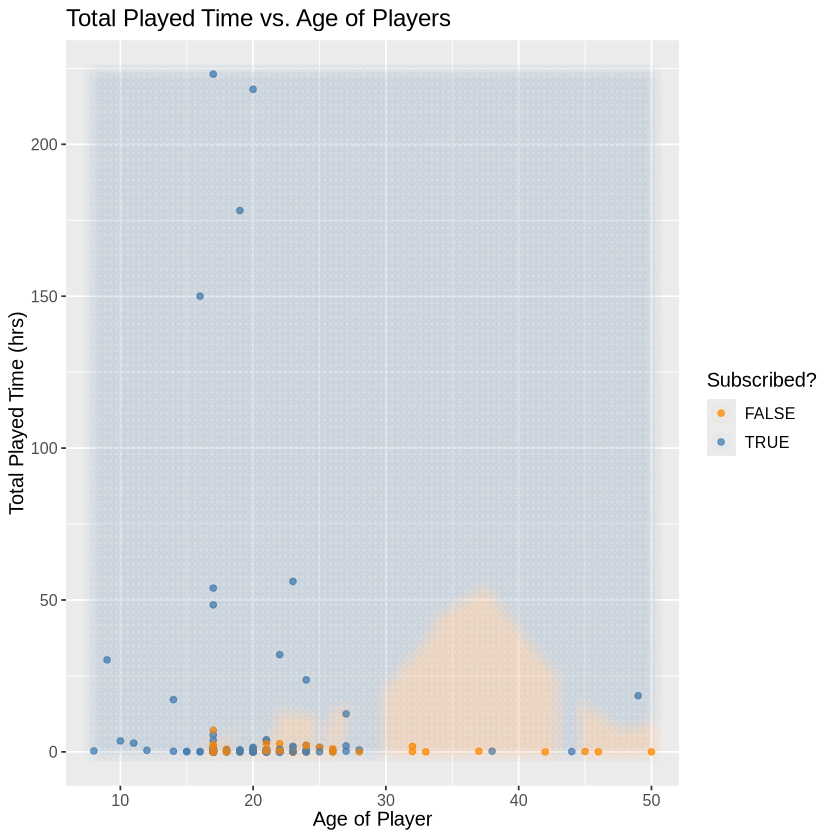

In [5]:
#Plotting the Classification Model 


# create the grid of area/smoothness vals, and arrange in a data frame
Age_grid <- seq(min(players_data$Age),
                max(players_data$Age),
                length.out = 100)
ph_grid <- seq(min(players_data$played_hours),
                max(players_data$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Age = Age_grid,
                                played_hours = ph_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict( players_fit , asgrid )

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) 

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
players_plot <- ggplot ( players_data , aes ( x = Age , y = played_hours, color = subscribe ) ) + 
    geom_point ( alpha = 0.75 ) +
    geom_point(data = prediction_table,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = .pred_class),
             alpha = 0.02,
             size = 5) +
    labs ( title = "Total Played Time vs. Age of Players" , 
          x = "Age of Player" , y = "Total Played Time (hrs)" , color = "Subscribed?" ) +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

players_plot